In [1]:
from itertools import izip, cycle
import os

import mica.archive.asp_l1
from astropy.table import Table
from Quaternion import Quat
from Ska.Numpy import interpolate
from Ska.Matplotlib import plot_cxctime
import matplotlib.pyplot as plt
from Ska.engarchive import fetch_eng as fetch
from kadi import events
from mica.archive import aca_l0
from scipy.stats import scoreatpercentile
import matplotlib
from matplotlib import cm
from Chandra.Time import DateTime
from Chandra.Maneuver import attitudes, inject_errors, get_quaternions

%matplotlib inline

import Ska.arc5gl

In [2]:
solfiles = mica.archive.asp_l1.get_files(obsid=19846, revision='last', content='ASPSOL')

In [3]:
grnd_sol = Table.read(solfiles[-1])

In [4]:
obcfile = 'pcadf595943989N001_osol1.fits.gz'
if not os.path.exists(obcfile):
    arc5gl = Ska.arc5gl.Arc5gl()
    arc5gl.sendline('obsid=19846')
    arc5gl.sendline('version=last')
    arc5gl.sendline('get asp1{obcsol}')
    del arc5gl

In [5]:
obc_sol = Table.read(obcfile)

In [6]:
# Some index magic to get things to line up.  
# Ground is sampled at 0.25625, OBC is 1.025 / sec.
obc_sol2 = obc_sol[-1330:-30]
grnd_sol2 = grnd_sol[-1300*4+2:-1:4]
np.max(obc_sol2['time'] - grnd_sol2['time'])

0.0

In [7]:
start = '2016:324:12:00:00'
stop = '2016:324:12:23:00'
R2A = np.degrees(1) * 3600

In [8]:
gb1 = fetch.Msid('aogbias1', start, stop)

In [9]:
def plot_att_changes(refs, atts, label):
    drs = []
    dps = []
    dys = []
    for ref_q, att_q in zip(cycle(refs['q_att']), atts['q_att']):
        dq = Quat(ref_q).dq(att_q)
        drs.append(dq.roll0 * 3600)
        dps.append(dq.pitch * 3600)
        dys.append(dq.yaw * 3600)

    plot_cxctime(obc_sol2['time'], drs, '-b', label='Roll')
    plot_cxctime(obc_sol2['time'], dps, '-g', label='Pitch')
    plot_cxctime(obc_sol2['time'], dys, '-m', label='Yaw')
    plt.grid()
    plt.margins(0.05)
    plt.title('{} before manvr prior to NSM'
              .format(label))
    plt.ylabel('Change (arcsec)')
    plt.legend(loc='best');

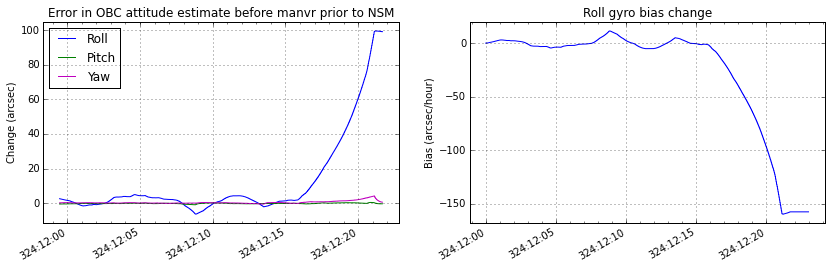

In [10]:
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plot_att_changes(grnd_sol2, obc_sol2, 'Error in OBC attitude estimate')

plt.subplot(1, 2, 2)
plot_cxctime(gb1.times, (gb1.vals - gb1.vals[0]) * R2A * 3600)
plt.grid()
plt.title('Roll gyro bias change')
plt.ylabel('Bias (arcsec/hour)')
plt.margins(0.05)

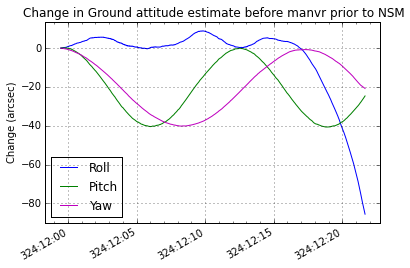

In [11]:
plot_att_changes(refs=grnd_sol2[:1], atts=grnd_sol2, 
                 label='Change in Ground attitude estimate')
# In this plot we see that the spacecraft was physically
# rolling by about 90 arcsec just prior to the maneuver.

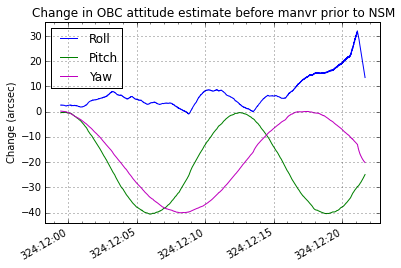

In [12]:
plot_att_changes(grnd_sol2[:1], obc_sol2, 'Change in OBC attitude estimate')
# This plot shows that the physical roll angle was not
# reflected in the on-board attitude estimate.

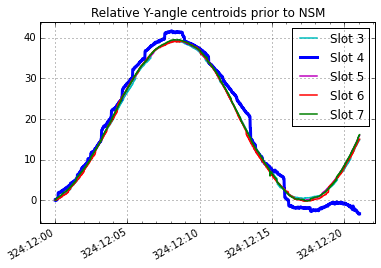

In [13]:
colors = 'cbmrg'

for slot, color in izip((3, 4, 5 ,6, 7), colors):
    lw = 3 if slot == 4 else 1.5
    yan = fetch.Msid('aoacyan{}'.format(slot), start, stop)
    yan.select_intervals(events.dwells(pad=-35))
    plot_cxctime(yan.times, yan.vals - yan.vals[0], color, 
                 label='Slot {}'.format(slot), lw=lw)
plt.margins(0.05)
plt.grid()
plt.legend(loc='upper right')
plt.title('Relative Y-angle centroids prior to NSM');

In [14]:
slot_data = aca_l0.get_slot_data('2016:324:12:14:00', '2016:324:12:20:30', slot=4)

In [15]:
vmax = scoreatpercentile(np.ravel(slot_data['IMGRAW']), 98)
vmin = scoreatpercentile(np.ravel(slot_data['IMGRAW']), 2)

In [16]:
DateTime(slot_data[120]['TIME']).date

'2016:324:12:18:06.782'

In [17]:
imgs = slot_data['IMGRAW'].reshape((-1, 8, 8))
imgs = imgs[:, :6, :6].filled(0)

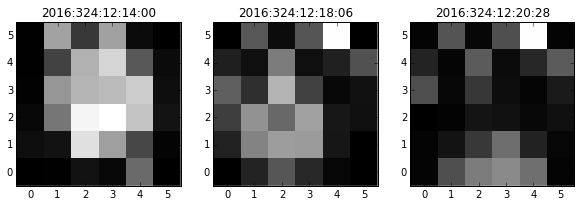

In [18]:
plt.figure(figsize=(10, 4))
for sub, idx in ((1, 0), (2, 120), (3, -1)):
    plt.subplot(1, 3, sub)
    plt.imshow(imgs[idx],
               interpolation='none',
               cmap=cm.gray,
               origin='lower',
               aspect='equal')
    plt.title(DateTime(slot_data['TIME'][idx]).date[:-4]);